<a href="https://colab.research.google.com/github/arkalim/Tensorflow/blob/master/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VLocNet 
 Localization is an indispensable component of a
robot’s autonomy stack that enables it to determine where it is
in the environment, essentially making it a precursor for any
action execution or planning. Although convolutional neural
networks have shown promising results for visual localization,
they are still grossly outperformed by state-of-the-art local
feature-based techniques. In this work, we propose VLocNet, a
new convolutional neural network architecture for 6-DoF global
pose regression and odometry estimation from consecutive
monocular images.

![alt text](http://deeploc.cs.uni-freiburg.de/static/images/cover_big.png)

In this notebook, we will train VLocNet on Microsoft 7-Scenes dataset.

## Proceed only if sufficient GPU memory is free

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]

if gpu.memoryFree < 15000:
    raise Exception('Insufficient GPU memory: {}MB'.format(gpu.memoryFree))   
else:
    print('Free GPU RAM: {}MB'.format(gpu.memoryFree))

Free GPU RAM: 15079.0MB


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Import necessary libraries
import os, datetime
import glob
import zipfile
import functools
#from pyquaternion import Quaternion
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import tensorflow as tf
import tensorflow.contrib as tfcontrib 
from keras.initializers import glorot_uniform

Using TensorFlow backend.


In [0]:
%%capture
img_shape = (640, 480, 3)
batch_size = 8
!pip install tfquaternion
import tfquaternion as tfq

## Function to overwrite the console output

In [0]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

# Download the checkpoint

In [6]:
!wget http://download.tensorflow.org/models/official/20181001_resnet/checkpoints/resnet_imagenet_v1_fp32_20181001.tar.gz
!tar xvzf 'resnet_imagenet_v1_fp32_20181001.tar.gz'    

checkpoint_dir="./resnet_imagenet_v1_fp32_20181001/"
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

print('Latest Checkpoint: {}'.format(latest_checkpoint))

--2019-07-10 17:09:39--  http://download.tensorflow.org/models/official/20181001_resnet/checkpoints/resnet_imagenet_v1_fp32_20181001.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.212.128, 2607:f8b0:4001:c14::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.212.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2065942827 (1.9G) [application/x-tar]
Saving to: ‘resnet_imagenet_v1_fp32_20181001.tar.gz.1’

resnet_imagenet_v1_ 100%[===================>]   1.92G   113MB/s    in 21s     

2019-07-10 17:10:01 (92.3 MB/s) - ‘resnet_imagenet_v1_fp32_20181001.tar.gz.1’ saved [2065942827/2065942827]

./resnet_imagenet_v1_fp32_20181001/
./resnet_imagenet_v1_fp32_20181001/model.ckpt-222860.data-00001-of-00002
./resnet_imagenet_v1_fp32_20181001/model.ckpt-223668.index
./resnet_imagenet_v1_fp32_20181001/model.ckpt-224474.meta
./resnet_imagenet_v1_fp32_20181001/model.ckpt-222061.meta
./resnet_imagenet_v1_fp32_20181001/m

# Create new checkpoints to load the weights

In [7]:
variables = tf.contrib.framework.list_variables(checkpoint_dir)

print('Total Number of Variables: {}'.format(len(variables)))

for idx, variable in enumerate(variables):
    print('Index: {}'.format(idx) + '   Variable: {}'.format(variable))

Total Number of Variables: 429
Index: 0   Variable: ('global_step', [])
Index: 1   Variable: ('resnet_model/batch_normalization/beta', [64])
Index: 2   Variable: ('resnet_model/batch_normalization/beta/Momentum', [64])
Index: 3   Variable: ('resnet_model/batch_normalization/gamma', [64])
Index: 4   Variable: ('resnet_model/batch_normalization/gamma/Momentum', [64])
Index: 5   Variable: ('resnet_model/batch_normalization/moving_mean', [64])
Index: 6   Variable: ('resnet_model/batch_normalization/moving_variance', [64])
Index: 7   Variable: ('resnet_model/batch_normalization_1/beta', [256])
Index: 8   Variable: ('resnet_model/batch_normalization_1/beta/Momentum', [256])
Index: 9   Variable: ('resnet_model/batch_normalization_1/gamma', [256])
Index: 10   Variable: ('resnet_model/batch_normalization_1/gamma/Momentum', [256])
Index: 11   Variable: ('resnet_model/batch_normalization_1/moving_mean', [256])
Index: 12   Variable: ('resnet_model/batch_normalization_1/moving_variance', [256])
Ind

In [0]:
with tf.Graph().as_default(), tf.Session().as_default() as sess:

  variables_1 = []
  variables_2 = []  
  variables_pose = []  
    
  for name, shape in variables:
    v = tf.contrib.framework.load_variable(checkpoint_dir, name)
    variables_1.append(tf.Variable(v, name=name.replace('resnet_model', 'stream_1')))
    variables_2.append(tf.Variable(v, name=name.replace('resnet_model', 'stream_2')))
    variables_pose.append(tf.Variable(v, name=name.replace('resnet_model', 'pose_stream')))

  saver_1 = tf.train.Saver(variables_1)
  saver_2 = tf.train.Saver(variables_2)
  saver_pose = tf.train.Saver(variables_pose)  
    
  sess.run(tf.global_variables_initializer())

  saver_1.save(sess, './stream_1/save')
  saver_2.save(sess, './stream_2/save')
  saver_pose.save(sess, './stream_pose/save')
  
checkpoint_dir_1="./stream_1"
checkpoint_dir_2="./stream_2"
checkpoint_dir_pose="./stream_pose"

latest_ckp_1 = tf.train.latest_checkpoint(checkpoint_dir_1)
latest_ckp_2 = tf.train.latest_checkpoint(checkpoint_dir_2)
latest_ckp_pose = tf.train.latest_checkpoint(checkpoint_dir_pose)

In [9]:
variables = tf.contrib.framework.list_variables(checkpoint_dir_pose)

print('Total Number of Variables: {}'.format(len(variables)))

for idx, variable in enumerate(variables):
    print('Index: {}'.format(idx) + '   Variable: {}'.format(variable))

Total Number of Variables: 429
Index: 0   Variable: ('global_step_2', [])
Index: 1   Variable: ('pose_stream/batch_normalization/beta', [64])
Index: 2   Variable: ('pose_stream/batch_normalization/beta/Momentum', [64])
Index: 3   Variable: ('pose_stream/batch_normalization/gamma', [64])
Index: 4   Variable: ('pose_stream/batch_normalization/gamma/Momentum', [64])
Index: 5   Variable: ('pose_stream/batch_normalization/moving_mean', [64])
Index: 6   Variable: ('pose_stream/batch_normalization/moving_variance', [64])
Index: 7   Variable: ('pose_stream/batch_normalization_1/beta', [256])
Index: 8   Variable: ('pose_stream/batch_normalization_1/beta/Momentum', [256])
Index: 9   Variable: ('pose_stream/batch_normalization_1/gamma', [256])
Index: 10   Variable: ('pose_stream/batch_normalization_1/gamma/Momentum', [256])
Index: 11   Variable: ('pose_stream/batch_normalization_1/moving_mean', [256])
Index: 12   Variable: ('pose_stream/batch_normalization_1/moving_variance', [256])
Index: 13   V

# Download and prepare the dataset 

In [0]:
from zipfile import ZipFile

def download_dataset(scenes):

    for scene in scenes:
        os.chdir('/content')  
        
        if scene == 'stairs':
            if not os.path.exists('/content/stairs'):
                !wget http://download.microsoft.com/download/2/8/5/28564B23-0828-408F-8631-23B1EFF1DAC8/stairs.zip    
                !unzip 'stairs.zip' 
                os.remove('stairs.zip')
                
        if scene == 'office':
            if not os.path.exists('/content/office'):
                !wget http://download.microsoft.com/download/2/8/5/28564B23-0828-408F-8631-23B1EFF1DAC8/office.zip  
                !unzip 'office.zip' 
                os.remove('office.zip')
                
        if scene == 'chess':
            if not os.path.exists('/content/chess'):
                !wget http://download.microsoft.com/download/2/8/5/28564B23-0828-408F-8631-23B1EFF1DAC8/chess.zip    
                !unzip 'chess.zip' 
                os.remove('chess.zip')
                
        if scene == 'redkitchen':
            if not os.path.exists('/content/redkitchen'):
                !wget http://download.microsoft.com/download/2/8/5/28564B23-0828-408F-8631-23B1EFF1DAC8/redkitchen.zip 
                !unzip 'redkitchen.zip'
                os.remove('redkitchen.zip')
                
        if scene == 'heads':
            if not os.path.exists('/content/heads'):
                !wget http://download.microsoft.com/download/2/8/5/28564B23-0828-408F-8631-23B1EFF1DAC8/heads.zip
                !unzip 'heads.zip'
                os.remove('heads.zip')
                
        if scene == 'pumpkin':
            if not os.path.exists('/content/pumpkin'):
                !wget http://download.microsoft.com/download/2/8/5/28564B23-0828-408F-8631-23B1EFF1DAC8/pumpkin.zip
                !unzip 'pumpkin.zip'
                os.remove('pumpkin.zip')        
                
        if scene == 'fire':
            if not os.path.exists('/content/fire'):
                !wget http://download.microsoft.com/download/2/8/5/28564B23-0828-408F-8631-23B1EFF1DAC8/fire.zip
                !unzip 'fire.zip'
                os.remove('fire.zip')        

        os.chdir(scene)        
        for folder in os.listdir():
            if folder.startswith('seq') and folder.endswith('.zip'):
                print(folder)
                
                with ZipFile(folder, 'r') as zip_file:
                    filenames = zip_file.namelist()
                    for filename in filenames:
                        if filename.endswith('.txt') or filename.endswith('.png'):
                            zip_file.extract(filename)
                os.remove(str(folder))
        os.chdir('/content')                      

In [11]:
train_paths = ['stairs', 'office', 'heads', 'chess', 'redkitchen', 'pumpkin', 'fire']

download_dataset(train_paths) 

train_filenames = []
train_labels_filenames = []
valid_filenames = []
valid_labels_filenames = []

for train_path in train_paths:
    
    for folder in os.listdir(train_path):       

        if folder in ['seq-01']:
            for filename in os.listdir(os.path.join(train_path , folder)):

                if filename.endswith('color.png'):
                    valid_filenames.append(os.path.join(os.path.join(train_path , folder), filename))
                elif filename.endswith('pose.txt'):
                    valid_labels_filenames.append(os.path.join(os.path.join(train_path , folder), filename)) 
                    
        elif folder.startswith('seq'):
            for filename in os.listdir(os.path.join(train_path , folder)):

                if filename.endswith('color.png'):
                    train_filenames.append(os.path.join(os.path.join(train_path , folder), filename))
                elif filename.endswith('pose.txt'):
                    train_labels_filenames.append(os.path.join(os.path.join(train_path , folder), filename))             
                
train_filenames.sort()
train_labels_filenames.sort()
valid_filenames.sort()
valid_labels_filenames.sort()                
                
num_train_examples = len(train_filenames) 
num_val_examples = len(valid_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))                   

Number of training examples: 36500
Number of validation examples: 6500


In [12]:
train_filenames[:10]

['chess/seq-02/frame-000000.color.png',
 'chess/seq-02/frame-000001.color.png',
 'chess/seq-02/frame-000002.color.png',
 'chess/seq-02/frame-000003.color.png',
 'chess/seq-02/frame-000004.color.png',
 'chess/seq-02/frame-000005.color.png',
 'chess/seq-02/frame-000006.color.png',
 'chess/seq-02/frame-000007.color.png',
 'chess/seq-02/frame-000008.color.png',
 'chess/seq-02/frame-000009.color.png']

In [13]:
train_labels_filenames[:10]

['chess/seq-02/frame-000000.pose.txt',
 'chess/seq-02/frame-000001.pose.txt',
 'chess/seq-02/frame-000002.pose.txt',
 'chess/seq-02/frame-000003.pose.txt',
 'chess/seq-02/frame-000004.pose.txt',
 'chess/seq-02/frame-000005.pose.txt',
 'chess/seq-02/frame-000006.pose.txt',
 'chess/seq-02/frame-000007.pose.txt',
 'chess/seq-02/frame-000008.pose.txt',
 'chess/seq-02/frame-000009.pose.txt']

In [0]:
def quaternion_from_matrix(matrix, isprecise=False):
    """Return quaternion from rotation or transformation matrix."""

    M = np.array(matrix, dtype=np.float64, copy=False)[:4, :4]
    if isprecise:
        q = np.empty((4, ))
        t = np.trace(M)
        if t > M[3, 3]:
            q[0] = t
            q[3] = M[1, 0] - M[0, 1]
            q[2] = M[0, 2] - M[2, 0]
            q[1] = M[2, 1] - M[1, 2]
        else:
            i, j, k = 0, 1, 2
            if M[1, 1] > M[0, 0]:
                i, j, k = 1, 2, 0
            if M[2, 2] > M[i, i]:
                i, j, k = 2, 0, 1
            t = M[i, i] - (M[j, j] + M[k, k]) + M[3, 3]
            q[i] = t
            q[j] = M[i, j] + M[j, i]
            q[k] = M[k, i] + M[i, k]
            q[3] = M[k, j] - M[j, k]
            q = q[[3, 0, 1, 2]]
        q *= 0.5 / math.sqrt(t * M[3, 3])
    else:
        m00 = M[0, 0]
        m01 = M[0, 1]
        m02 = M[0, 2]
        m10 = M[1, 0]
        m11 = M[1, 1]
        m12 = M[1, 2]
        m20 = M[2, 0]
        m21 = M[2, 1]
        m22 = M[2, 2]
        # symmetric matrix K
        K = np.array([[m00-m11-m22, 0.0,         0.0,         0.0],
                         [m01+m10,     m11-m00-m22, 0.0,         0.0],
                         [m02+m20,     m12+m21,     m22-m00-m11, 0.0],
                         [m21-m12,     m02-m20,     m10-m01,     m00+m11+m22]])
        K /= 3.0
        # quaternion is eigenvector of K that corresponds to largest eigenvalue
        w, V = np.linalg.eigh(K)
        q = V[[3, 0, 1, 2], np.argmax(w)]
    if q[0] < 0.0:
        np.negative(q, q)
    return q

In [0]:
def label_to_transformation(filenames):
    
    translations = []
    quarternions = []


    for filename in filenames:
        
        transformation_matrix = []

        # Reading Text files line by line to parse them
        file = open(filename,'r')
        lines = file.readlines()

        for line_num in range(len(lines)):
            line = lines[line_num]
            r1 , r2 , r3 , t , _= line.split('\t')
            transformation_matrix.append([r1 , r2 , r3 , t])

        # specifying data type as the values are string by default    
        transformation_matrix = np.array(transformation_matrix, dtype = np.float32)

        translation = transformation_matrix[:3,3]
        quarternion = quaternion_from_matrix(transformation_matrix)

        
        translations.append(translation.tolist())
        quarternions.append(quarternion.tolist())
        
    return translations , quarternions 

train_translations , train_quarternions  = label_to_transformation(train_labels_filenames)
valid_translations , valid_quarternions  = label_to_transformation(valid_labels_filenames)

In [16]:
train_translations[:3]

[[-0.5840070843696594, -0.4401988089084625, -0.015013673342764378],
 [-0.5834411978721619, -0.44095978140830994, -0.014878423884510994],
 [-0.5825936794281006, -0.4406605660915375, -0.015282991342246532]]

In [17]:
train_quarternions[:3]

[[0.9513587178175625,
  -0.19046317383281214,
  0.23113467479843042,
  0.0722297137740332],
 [0.9511180584120453,
  -0.19333754987700225,
  0.22968865967878693,
  0.07237506742670956],
 [0.9510396911153977,
  -0.19347207210433567,
  0.22944220022084028,
  0.07381287148325437]]

In [18]:
valid_translations[:3]

[[-0.1232336089015007, -1.1206966638565063, -0.9887057542800903],
 [-0.13631822168827057, -1.122137188911438, -0.9885462522506714],
 [-0.13610802590847015, -1.1223994493484497, -0.9894663691520691]]

In [19]:
valid_quarternions[:3]

[[0.995185274488976,
  -0.09642250053707302,
  0.016435119174659008,
  0.00623359352178841],
 [0.9949398668686843,
  -0.09805450216010579,
  0.020571923823319183,
  0.0075347111202866204],
 [0.9948223498240407,
  -0.0991831952459202,
  0.02096396877055373,
  0.007190138021672007]]

## Pair consecutive frames

In [0]:
# Function to generate consecutive pairs of images
def pair(arr):
    paired = []
    for i in range(len(arr)-1):
        paired.append([arr[i], arr[i + 1]])
    return paired


  
train_filenames_ = pair(train_filenames)
valid_filenames_ = pair(valid_filenames)
train_translations_ = pair(train_translations)
train_quarternions_ = pair(train_quarternions)
valid_translations_ = pair(valid_translations)
valid_quarternions_ = pair(valid_quarternions)

## Remove inter-sequential pairs

In [0]:
def filter_(filenames, translations, quarternions):
    
    new_filenames = []
    new_translations = []
    new_quarternions = []
    
    for index in range(len(filenames)):
        # if both the images in the pair belong to the same sequence
        if filenames[index][0][:14] == filenames[index][1][:14]:
            new_filenames.append(filenames[index])
            new_translations.append(translations[index])
            new_quarternions.append(quarternions[index])
            
    return new_filenames, new_translations, new_quarternions            
        
train_filenames, train_translations, train_quarternions = filter_(train_filenames_, train_translations_, train_quarternions_)
valid_filenames, valid_translations, valid_quarternions = filter_(valid_filenames_, valid_translations_, valid_quarternions_)

# Visualise the dataset
Here is how the images and masks in the dataset look like

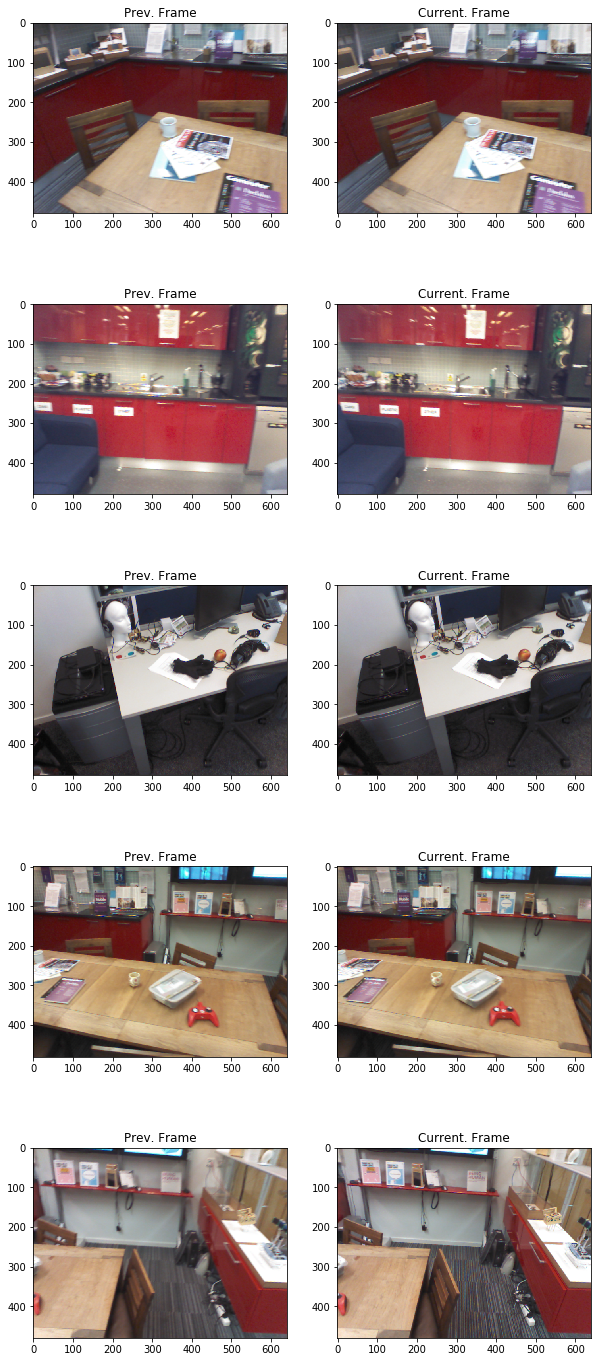

In [22]:
# Number of items to be displayed
display_num = 5

# Randomly selecting the examples from the dataset
random_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, display_num * 5))

for i in range(display_num):
    
    img_num = random_choices[i]

    x_pathname = train_filenames[img_num]

    plt.subplot(display_num,2,2*i+1)  
    plt.imshow(mpimg.imread(x_pathname[0]))
    plt.title("Prev. Frame")

    plt.subplot(display_num,2,2*i+2)
    plt.imshow(mpimg.imread(x_pathname[1]))
    plt.title("Current. Frame")

plt.show()

In [23]:
print(train_translations[0])
print(train_quarternions[0])

[[-0.5840070843696594, -0.4401988089084625, -0.015013673342764378], [-0.5834411978721619, -0.44095978140830994, -0.014878423884510994]]
[[0.9513587178175625, -0.19046317383281214, 0.23113467479843042, 0.0722297137740332], [0.9511180584120453, -0.19333754987700225, 0.22968865967878693, 0.07237506742670956]]


In [0]:
# Function that performs all the required augmentations
class augment(object):
    
    def __init__(self, scale = 1, img_shape = (640, 480, 3), crop_size = None, random = False):

        self.scale = scale
        self.crop_size = crop_size
        self.random = random
        self.img_shape = img_shape
       
    def zoom(self, image, translation, quarternion):
        
        """Zoom augmentation

        Args:
            image: Image

        Returns:
            Augmented image
        """

        if self.crop_size is not None:
            
            if self.random:
                
                # Generate 20 crop settings, ranging from a 1% to 20% crop.
                scales = list(np.arange(0.8, 1.0, 0.01))
                boxes = np.zeros((len(scales), 4))

                for i, scale in enumerate(scales):
                    x1 = y1 = 0.5 - (0.5 * scale)
                    x2 = y2 = 0.5 + (0.5 * scale)
                    boxes[i] = [x1, y1, x2, y2]

                def random_crop(img):
                    # Create different crops for an image
                    crops = tf.image.crop_and_resize([img], boxes=boxes, box_ind=np.zeros(len(scales)), crop_size=self.crop_size)
                    # Return a random crop
                    return crops[tf.random_uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

                image_0 = random_crop(image[0])
                image_1 = random_crop(image[1])
                
                image = [image_0 , image_1]

                # Only apply cropping 70% of the time
                return image, translation, quarternion
            
            else:
                
                offset_height = int((self.img_shape[1] - self.crop_size[1])//2)
                offset_width = int((self.img_shape[0] - self.crop_size[0])//2)
                target_height = self.crop_size[1]
                target_width = self.crop_size[0]
                
                image_0 = tf.image.crop_to_bounding_box(image[0], offset_height, offset_width, target_height, target_width)
                image_1 = tf.image.crop_to_bounding_box(image[1], offset_height, offset_width, target_height, target_width)
                
                image = [image_0 , image_1]
                
                return image, translation, quarternion
        
        else:
            return image, translation, quarternion
        
    def normalize(self, image, translation, quarternion):
        image = tf.image.per_image_standardization(image)
        return image, translation, quarternion
        
    
    def __call__(self, image, translation, quarternion):
        
            
        image, translation, quarternion = self.zoom(image, translation, quarternion)    
       
        image_0 = tf.to_float(image[0]) * self.scale 
        image_1 = tf.to_float(image[1]) * self.scale 
        
        image = [image_0 , image_1]
        
        image, translation, quarternion = self.normalize(image, translation, quarternion)

        return image, translation, quarternion

In [0]:
train_augment = augment(scale = 1/255., img_shape = (640, 480, 3), crop_size = (224,224), random = True)

valid_augment = augment(scale = 1/255., img_shape = (640, 480, 3), crop_size = (224,224), random = False)

In [0]:
def process_filenames(filename, translation, quarternion):
   
    img_str_0 = tf.read_file(filename[0])
    img_str_1 = tf.read_file(filename[1])
    
    image_0 = tf.image.decode_jpeg(img_str_0, channels=3)
    image_1 = tf.image.decode_jpeg(img_str_1, channels=3)
    
    image = [image_0 , image_1]

    return image, translation, quarternion

In [27]:
# Function to create a dataset after data augmentation
def get_dataset(filenames, translations, quarternions, shuffle, batch_size, preprocess_func, name = 'dataset'):
               
    with tf.name_scope(name):    
        
        num_x = len(filenames)

        # Create a dataset from the filenames and labels
        dataset = tf.data.Dataset.from_tensor_slices((filenames, translations, quarternions)) 

        dataset = dataset.map(process_filenames, num_parallel_calls = 5)

        dataset = dataset.map(preprocess_func, num_parallel_calls = 5)


        if shuffle:
            dataset = dataset.shuffle(buffer_size=1000)

        # It's necessary to repeat our data for all epochs 
        dataset = dataset.repeat().batch(batch_size)

        return dataset

# Prepare training dataset
train_ds = get_dataset(train_filenames, train_translations, train_quarternions, shuffle = True, batch_size = batch_size, preprocess_func = train_augment, name = 'train_dataset')

# Prepare training dataset
valid_ds = get_dataset(valid_filenames, valid_translations, valid_quarternions, shuffle = False, batch_size = batch_size, preprocess_func = valid_augment, name = 'valid_dataset')

W0710 17:11:56.170246 139776877619072 deprecation.py:506] From <ipython-input-24-37f00595a838>:36: calling crop_and_resize_v1 (from tensorflow.python.ops.image_ops_impl) with box_ind is deprecated and will be removed in a future version.
Instructions for updating:
box_ind is deprecated, use box_indices instead
W0710 17:11:56.196363 139776877619072 deprecation.py:323] From <ipython-input-24-37f00595a838>:75: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0710 17:11:56.216462 139776877619072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/image_ops_impl.py:1514: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# Visuslise Training Dataset(randomly cropped images) 

W0710 17:11:59.484496 139776877619072 deprecation.py:323] From <ipython-input-28-3dbfffd30141>:9: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W0710 17:12:47.505643 139776877619072 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0710 17:12:47.523189 139776877619072 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0710 17:12:47.536556 139776877619072 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0710 17:12:47.549583 139776877

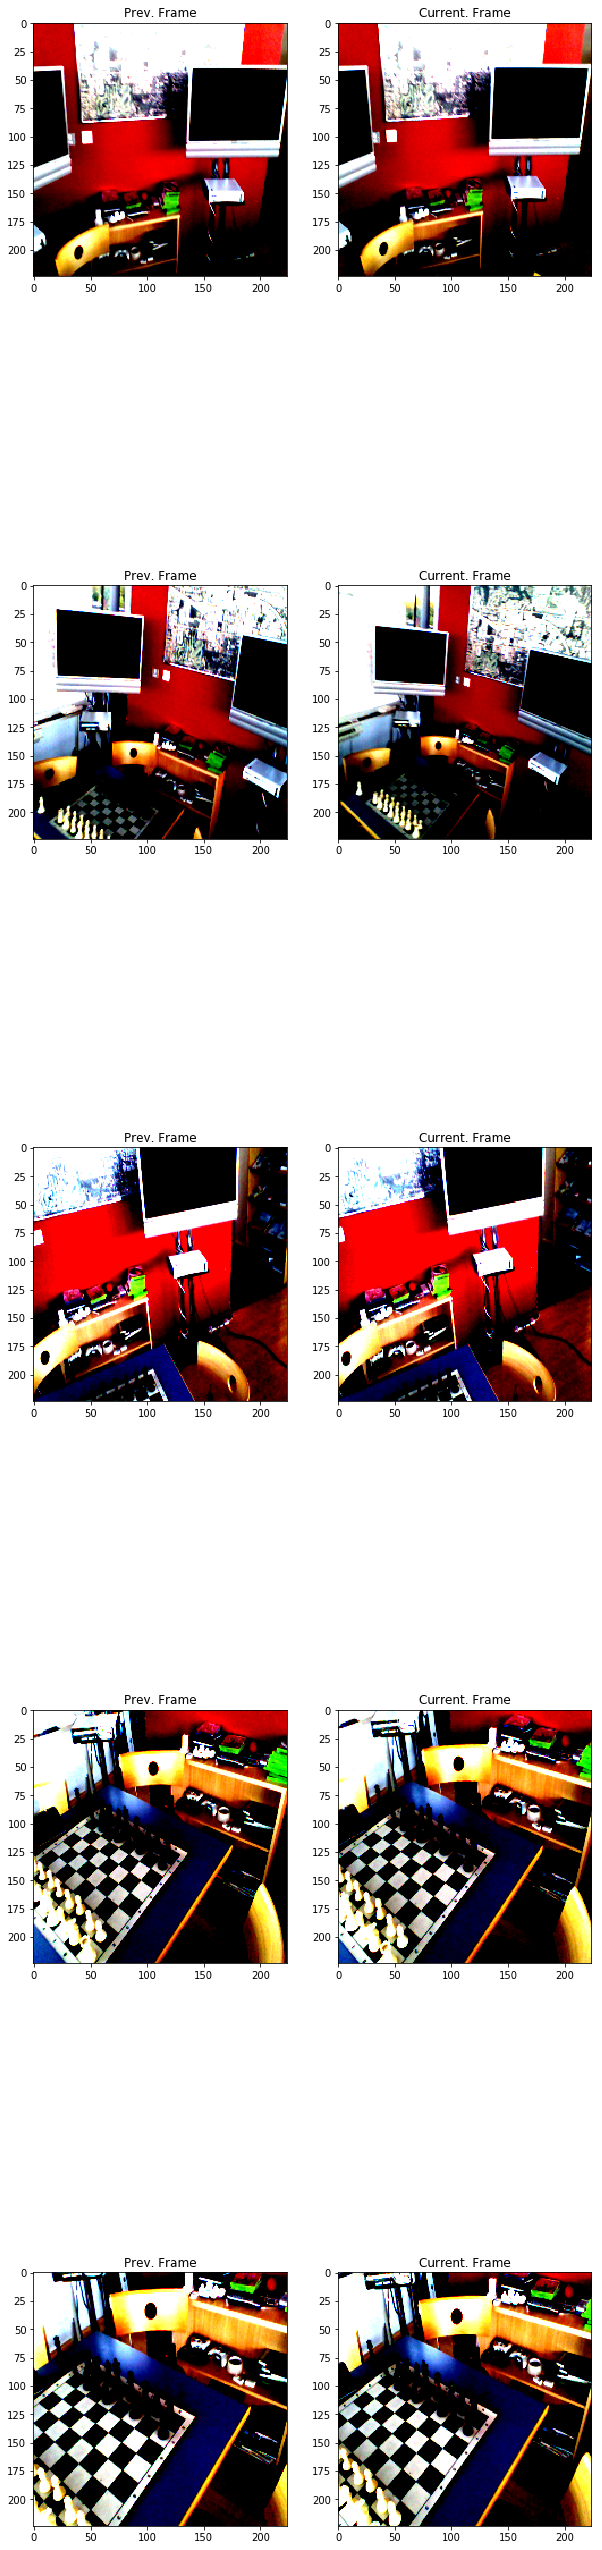

In [28]:
temp_ds = get_dataset(train_filenames, train_translations, train_quarternions, shuffle = True, batch_size = batch_size, preprocess_func = train_augment, name = 'temp_dataset')

display_num = 5

# Randomly selecting the examples from the dataset
random_choices = np.random.choice(batch_size, display_num)

# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce an image since batch size = 1
with tf.Session() as sess: 
    img, translation, quarternion = sess.run(next_element)

    plt.figure(figsize=(10, 10 * display_num))

    for i in range(display_num):

        img_num = random_choices[i]

        plt.subplot(display_num,2,2*i+1)  
        plt.imshow(img[img_num,0,:,:,:])
        plt.title("Prev. Frame")

        plt.subplot(display_num,2,2*i+2)
        plt.imshow(img[img_num,1,:,:,:])
        plt.title("Current. Frame")


# Visualise Validation Dataset (Centre Cropped Images)

W0710 17:13:09.209805 139776877619072 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0710 17:13:09.231235 139776877619072 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0710 17:13:09.249793 139776877619072 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0710 17:13:09.264612 139776877619072 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0710 17:13:09.278827 139776877619072 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0710 17:13:09.291405 139776877619072 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0710 17:13:09.303679 139776

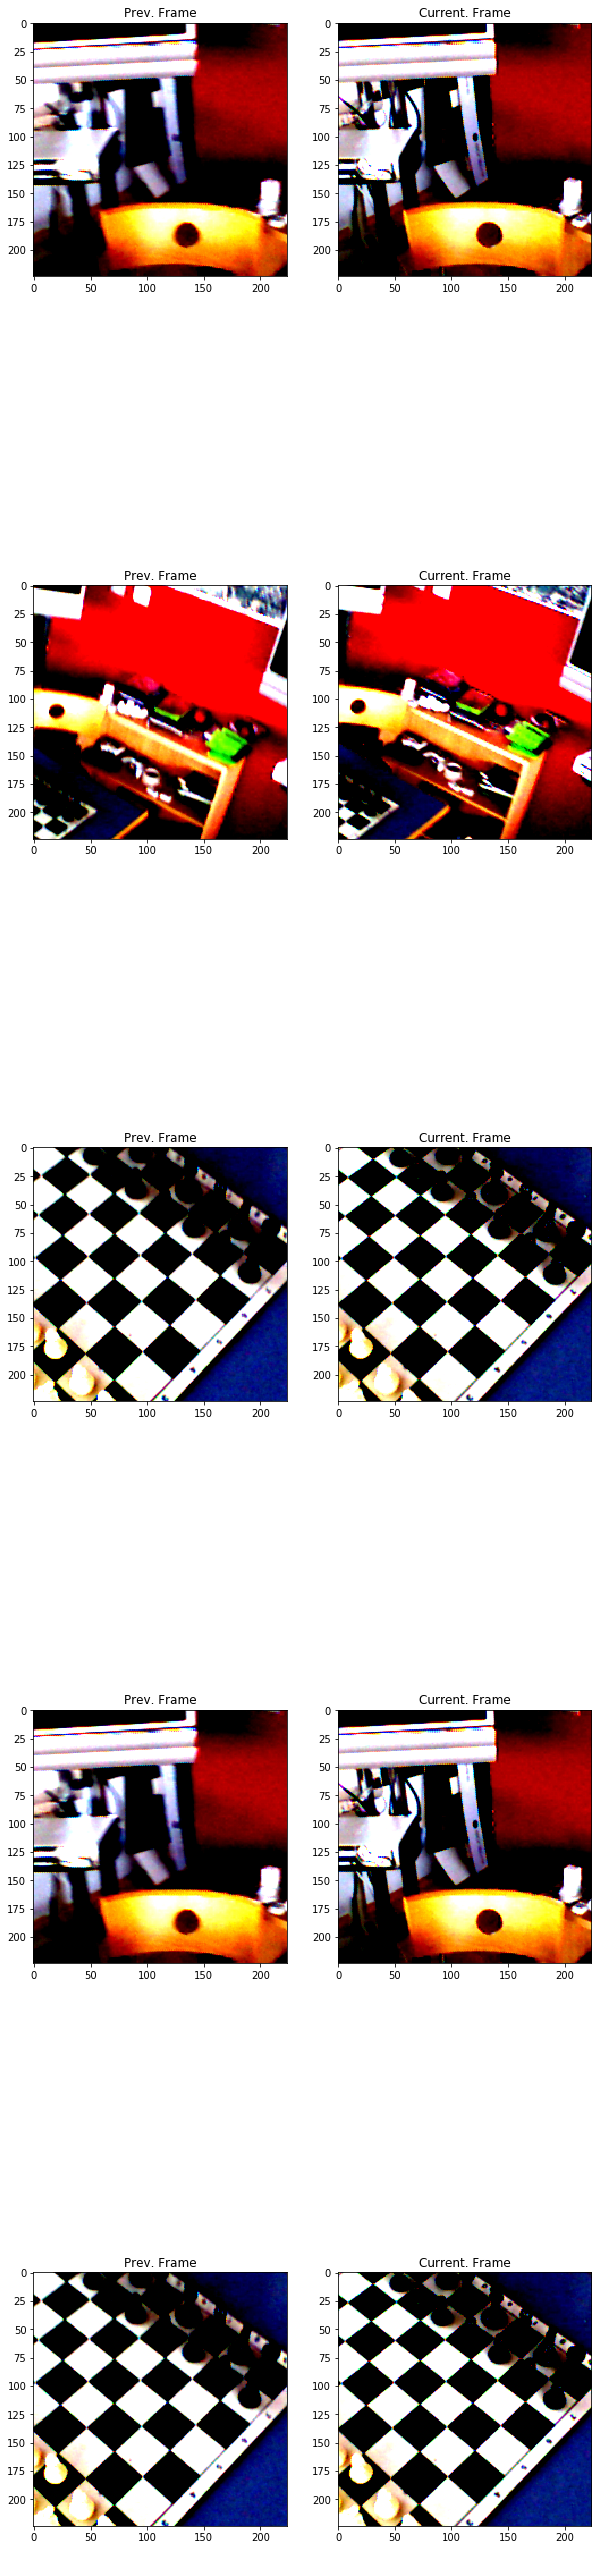

In [29]:
temp_valid_ds = get_dataset(valid_filenames, valid_translations, valid_quarternions, shuffle = True, batch_size = batch_size, preprocess_func = valid_augment, name = 'temp_valid_dataset')

display_num = 5

# Randomly selecting the examples from the dataset
random_choices = np.random.choice(batch_size, display_num)

# Let's examine some of these augmented images
data_aug_iter = temp_valid_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce an image since batch size = 1
with tf.Session() as sess: 
    img, translation, quarternion = sess.run(next_element)

    plt.figure(figsize=(10, 10 * display_num))

    for i in range(display_num):

        img_num = random_choices[i]

        plt.subplot(display_num,2,2*i+1)  
        plt.imshow(img[img_num,0,:,:,:])
        plt.title("Prev. Frame")

        plt.subplot(display_num,2,2*i+2)
        plt.imshow(img[img_num,1,:,:,:])
        plt.title("Current. Frame")


# Load the model

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

_BATCH_NORM_DECAY = 0.997
_BATCH_NORM_EPSILON = 1e-5
DEFAULT_DTYPE = tf.float32
CASTABLE_TYPES = (tf.float16,)
ALLOWED_TYPES = (DEFAULT_DTYPE,) + CASTABLE_TYPES


################################################################################
# Convenience functions for building the ResNet model.
################################################################################
def batch_norm(inputs):

  return tf.compat.v1.layers.batch_normalization(
      inputs=inputs, axis = 3,
      momentum=_BATCH_NORM_DECAY, epsilon=_BATCH_NORM_EPSILON, center=True,
      scale=True, training= True, fused=True)


def fixed_padding(inputs, kernel_size):

  pad_total = kernel_size - 1
  pad_beg = pad_total // 2
  pad_end = pad_total - pad_beg

  padded_inputs = tf.pad(tensor=inputs,
                           paddings=[[0, 0], [pad_beg, pad_end],
                                     [pad_beg, pad_end], [0, 0]])
  return padded_inputs


def conv2d_fixed_padding(inputs, filters, kernel_size, strides):
  """Strided 2-D convolution with explicit padding."""
  # The padding is consistent and is based only on `kernel_size`, not on the
  # dimensions of `inputs` (as opposed to using `tf.layers.conv2d` alone).
  if strides > 1:
    inputs = fixed_padding(inputs, kernel_size)

  return tf.compat.v1.layers.conv2d(
      inputs=inputs, filters=filters, kernel_size=kernel_size, strides=strides,
      padding=('SAME' if strides == 1 else 'VALID'), use_bias=False,
      kernel_initializer=tf.compat.v1.variance_scaling_initializer())


################################################################################
# ResNet block definitions.
################################################################################
def bottleneck_block(inputs, filters, projection_shortcut, strides):
    
  shortcut = inputs

  if projection_shortcut is not None:
    shortcut = projection_shortcut(inputs)
    shortcut = batch_norm(inputs=shortcut)

  inputs = conv2d_fixed_padding(
      inputs=inputs, filters=filters, kernel_size=1, strides=1)
  inputs = batch_norm(inputs)
  inputs = tf.nn.elu(inputs)

  inputs = conv2d_fixed_padding(
      inputs=inputs, filters=filters, kernel_size=3, strides=strides)
  inputs = batch_norm(inputs)
  inputs = tf.nn.elu(inputs)

  inputs = conv2d_fixed_padding(inputs=inputs, filters=4 * filters, kernel_size=1, strides=1)
  inputs = batch_norm(inputs)
    
  inputs += shortcut
  inputs = tf.nn.elu(inputs)

  return inputs

def block_layer(inputs, filters, blocks, strides, name):

  # Bottleneck blocks end with 4x the number of filters as they start with
  filters_out = filters * 4 

  def projection_shortcut(inputs):
    return conv2d_fixed_padding(inputs=inputs, filters=filters_out, kernel_size=1, strides=strides)

  # Only the first block per block_layer uses projection_shortcut and strides
  inputs = bottleneck_block(inputs, filters, projection_shortcut, strides)

  for _ in range(1, blocks):
    inputs = bottleneck_block(inputs, filters, None, 1)

  return tf.identity(inputs, name)


class input_stream(object):

  def __init__(self, num_filters, kernel_size,
               conv_stride, first_pool_size, first_pool_stride,
               block_sizes, block_strides, dtype=DEFAULT_DTYPE, scope_name = 'resnet_model'):

    if dtype not in ALLOWED_TYPES:
      raise ValueError('dtype must be one of: {}'.format(ALLOWED_TYPES))
    
    self.num_filters = num_filters
    self.kernel_size = kernel_size
    self.conv_stride = conv_stride
    self.first_pool_size = first_pool_size
    self.first_pool_stride = first_pool_stride
    self.block_sizes = block_sizes
    self.block_strides = block_strides
    self.dtype = dtype
    self.scope_name = scope_name

  def _custom_dtype_getter(self, getter, name, shape=None, dtype=DEFAULT_DTYPE,
                           *args, **kwargs):

    if dtype in CASTABLE_TYPES:
      var = getter(name, shape, tf.float32, *args, **kwargs)
      return tf.cast(var, dtype=dtype, name=name + '_cast')
    else:
      return getter(name, shape, dtype, *args, **kwargs)

  def _model_variable_scope(self):

    return tf.compat.v1.variable_scope(self.scope_name, custom_getter=self._custom_dtype_getter)

  def __call__(self, inputs):


    with self._model_variable_scope():

      inputs = conv2d_fixed_padding(inputs= inputs, filters=self.num_filters, kernel_size=self.kernel_size, strides=self.conv_stride)
      inputs = tf.identity(inputs, 'initial_conv')
      inputs = batch_norm(inputs)
      inputs = tf.nn.relu(inputs)

      if self.first_pool_size:
        inputs = tf.compat.v1.layers.max_pooling2d(inputs=inputs, pool_size=self.first_pool_size, strides=self.first_pool_stride, padding='SAME')
        inputs = tf.identity(inputs, 'initial_max_pool')
        
      num_filters = self.num_filters * (2**0)
      inputs = block_layer(inputs=inputs, filters=num_filters, blocks=self.block_sizes[0], strides=self.block_strides[0], name='block_layer1')
        
      num_filters = self.num_filters * (2**1)
      pose_inputs = block_layer(inputs=inputs, filters=num_filters, blocks=self.block_sizes[1], strides=self.block_strides[1], name='block_layer2')  
        
      num_filters = self.num_filters * (2**2)
      inputs = block_layer(inputs=pose_inputs, filters=num_filters, blocks=self.block_sizes[2], strides=self.block_strides[2], name='block_layer3')    
        
    return inputs, pose_inputs 

class odometry_stream(object):

  def __init__(self, block_size, block_stride, dtype=DEFAULT_DTYPE, scope_name = 'resnet_model'):

    if dtype not in ALLOWED_TYPES:
      raise ValueError('dtype must be one of: {}'.format(ALLOWED_TYPES))
    
    self.block_size = block_size
    self.block_stride = block_stride
    self.dtype = dtype
    self.scope_name = scope_name

  def _custom_dtype_getter(self, getter, name, shape=None, dtype=DEFAULT_DTYPE,
                           *args, **kwargs):

    if dtype in CASTABLE_TYPES:
      var = getter(name, shape, tf.float32, *args, **kwargs)
      return tf.cast(var, dtype=dtype, name=name + '_cast')
    else:
      return getter(name, shape, dtype, *args, **kwargs)

  def _model_variable_scope(self):

    return tf.compat.v1.variable_scope(self.scope_name, custom_getter=self._custom_dtype_getter)

  def __call__(self, input_1, input_2):
        
    with self._model_variable_scope():    
        
      con = tf.concat([input_1 , input_2], axis = 3)  
      num_filters = int(con.shape[3])    

      inputs = block_layer(inputs=con, filters = num_filters, blocks=self.block_size, strides=self.block_stride, name='block_layer{}'.format(4))
        
      axes = [1, 2]
      inputs = tf.reduce_mean(input_tensor=inputs, axis=axes, keepdims=True)
      inputs = tf.identity(inputs, 'final_reduce_mean')

      flattened = tf.squeeze(inputs, axes)

      inputs = tf.layers.dense(inputs = flattened, units = 1024, kernel_initializer = tf.initializers.glorot_normal(seed = 42))
      position = tf.layers.dense(inputs = inputs, units = 3, kernel_initializer = tf.initializers.glorot_normal(seed = 42))
      orientation = tf.layers.dense(inputs = inputs, units = 4, kernel_initializer = tf.initializers.glorot_normal(seed = 42))

    return position, orientation 

class pose_stream(object):

  def __init__(self, block_sizes, block_strides, dtype=DEFAULT_DTYPE, scope_name = 'resnet_model'):

    if dtype not in ALLOWED_TYPES:
      raise ValueError('dtype must be one of: {}'.format(ALLOWED_TYPES))
    
    self.block_sizes = block_sizes
    self.block_strides = block_strides
    self.dtype = dtype
    self.scope_name = scope_name

  def _custom_dtype_getter(self, getter, name, shape=None, dtype=DEFAULT_DTYPE,
                           *args, **kwargs):

    if dtype in CASTABLE_TYPES:
      var = getter(name, shape, tf.float32, *args, **kwargs)
      return tf.cast(var, dtype=dtype, name=name + '_cast')
    else:
      return getter(name, shape, dtype, *args, **kwargs)

  def _model_variable_scope(self):

    return tf.compat.v1.variable_scope(self.scope_name, custom_getter=self._custom_dtype_getter)

  def __call__(self, pose_inputs_1, position_prev, orientation_prev):
        
    print(position_prev)    
    print(orientation_prev)
        
    feed = tf.concat([position_prev, orientation_prev], axis = 1)   
    
    feed = tf.layers.dense(inputs = feed, units = 14 * 14 * 1024, kernel_initializer = tf.initializers.glorot_normal(seed = 42))
    
    feed = tf.reshape(feed, shape = [-1,14,14,1024])
        
    with self._model_variable_scope():     
        
      num_filters = 64 * (2**2)
      inputs = block_layer(inputs=pose_inputs_1, filters=num_filters, blocks=self.block_sizes[0], strides=self.block_strides[0], name='block_layer3') 
        
      inputs = tf.concat([inputs, feed], axis = -1)  
        
      num_filters = 64 * (2**3)  
      inputs = block_layer(inputs=inputs, filters = num_filters, blocks=self.block_sizes[1], strides=self.block_strides[1], name='block_layer4')
        
      axes = [1, 2]
      inputs = tf.reduce_mean(input_tensor=inputs, axis=axes, keepdims=True)
      inputs = tf.identity(inputs, 'final_reduce_mean')

      flattened = tf.squeeze(inputs, axes)

      inputs = tf.layers.dense(inputs = flattened, units = 1024, kernel_initializer = tf.initializers.glorot_normal(seed = 42))
      position = tf.layers.dense(inputs = inputs, units = 3, kernel_initializer = tf.initializers.glorot_normal(seed = 42))
      orientation = tf.layers.dense(inputs = inputs, units = 4, kernel_initializer = tf.initializers.glorot_normal(seed = 42))

    return position, orientation 

stream_1 = input_stream(num_filters = 64, kernel_size = 7, conv_stride = 2, first_pool_size = 3, first_pool_stride = 2, block_sizes = [3,4,6], block_strides =[1,2,2], scope_name = 'stream_1')

stream_2 = input_stream(num_filters = 64, kernel_size = 7, conv_stride = 2, first_pool_size = 3, first_pool_stride = 2, block_sizes = [3,4,6], block_strides =[1,2,2], scope_name = 'stream_2')

stream_odom = odometry_stream(block_size = 3, block_stride = 2, scope_name = 'odom_stream')

stream_pose = pose_stream(block_sizes = [6,3], block_strides = [2,2], scope_name = 'pose_stream')


In [31]:
with tf.name_scope("Placeholders"):    
    handle = tf.placeholder(tf.string, shape=[])   
    
# create initializable iterators from the dataset
train_iterator = train_ds.make_initializable_iterator()
valid_iterator = valid_ds.make_initializable_iterator() 
    
iterator = tf.data.Iterator.from_string_handle(handle, train_ds.output_types, train_ds.output_shapes)
next_element = iterator.get_next()
frames, position_true, orientation_true = next_element

input_1, pose_inputs_1 = stream_1(frames[:,0,:,:,:])
input_2, pose_inputs_2 = stream_2(frames[:,1,:,:,:])

odom_position_pred, odom_orientation_pred = stream_odom(input_1, input_2)
pose_position_pred, pose_orientation_pred = stream_pose(pose_inputs_2, position_true[:,0], orientation_true[:,0])

W0710 17:13:12.218844 139776877619072 deprecation.py:323] From <ipython-input-31-e7a4ec1aad3e>:5: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
W0710 17:13:12.231944 139776877619072 deprecation.py:323] From <ipython-input-31-e7a4ec1aad3e>:8: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
W0710 17:13:12.232697 139776877619072 deprecation.py:323] From <ipython-input-31-e7a4ec1aad3e>:8: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a 

Tensor("strided_slice_2:0", shape=(?, 3), dtype=float32)
Tensor("strided_slice_3:0", shape=(?, 4), dtype=float32)


# Restore the model

In [32]:
variable_1= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='stream_1')
variable_2=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='stream_2')
variable_odom=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='odom_stream')

saver_1 = tf.train.Saver(variable_1[:len(variable_1)])
saver_2 = tf.train.Saver(variable_2[:len(variable_2)])

with tf.Session() as sess:
    
  sess.run(tf.global_variables_initializer())

  # Restore variables from disk.
  saver_1.restore(sess, latest_ckp_1)
  saver_2.restore(sess, latest_ckp_2)  

  print("Model restored.")    

W0710 17:13:20.337562 139776877619072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Model restored.


# Define Loss and Optimizer

In [33]:
# function to perform quarternion difference
def quaternion_diff(q_new,q_old):
	mod=tfq.quaternion_multiply(q_old,tfq.quaternion_conjugate(q_old))
	q_old_inverse=tfq.quaternion_conjugate(q_old)/mod
	relq=tfq.quaternion_multiply(q_old_inverse,q_new)
	return relq

with tf.name_scope("Loss"):    
# Defining the loss function
  pose_position_loss = tf.losses.mean_squared_error(labels = position_true[:,1], predictions = pose_position_pred) 
  pose_orientation_loss = tf.losses.mean_squared_error(labels = orientation_true[:,1], predictions = pose_orientation_pred)

  odom_position_loss = tf.losses.mean_squared_error(labels = (position_true[:,1]-position_true[:,0]) ,predictions = odom_position_pred) 
  odom_orientation_loss = tf.losses.mean_squared_error(labels= quaternion_diff(orientation_true[:,1],orientation_true[:,0]) , predictions = odom_orientation_pred)  

  s1 = tf.get_variable('s01',initializer=tf.constant(-0.1),trainable=True)
  s2 = tf.get_variable('s02',initializer=tf.constant(-3.0),trainable=True)    

  geometric_loss = tf.exp(-s1)*(pose_position_loss + odom_position_loss)+ s1 + tf.exp(-s2)*(pose_orientation_loss + odom_orientation_loss)+ s2
    
#### Print trainable variables ####   
variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)  
print('Total Number of Variables: {}'.format(len(variables)))

for idx, variable in enumerate(variables):
    print('Index: {}'.format(idx) + '   Variable: {}'.format(variable))

W0710 17:13:21.665210 139776877619072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0710 17:13:21.752733 139776877619072 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tfquaternion/tfquaternion.py:389: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Total Number of Variables: 391
Index: 0   Variable: <tf.Variable 'stream_1/conv2d/kernel:0' shape=(7, 7, 3, 64) dtype=float32_ref>
Index: 1   Variable: <tf.Variable 'stream_1/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>
Index: 2   Variable: <tf.Variable 'stream_1/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>
Index: 3   Variable: <tf.Variable 'stream_1/conv2d_1/kernel:0' shape=(1, 1, 64, 256) dtype=float32_ref>
Index: 4   Variable: <tf.Variable 'stream_1/batch_normalization_1/gamma:0' shape=(256,) dtype=float32_ref>
Index: 5   Variable: <tf.Variable 'stream_1/batch_normalization_1/beta:0' shape=(256,) dtype=float32_ref>
Index: 6   Variable: <tf.Variable 'stream_1/conv2d_2/kernel:0' shape=(1, 1, 64, 64) dtype=float32_ref>
Index: 7   Variable: <tf.Variable 'stream_1/batch_normalization_2/gamma:0' shape=(64,) dtype=float32_ref>
Index: 8   Variable: <tf.Variable 'stream_1/batch_normalization_2/beta:0' shape=(64,) dtype=float32_ref>
Index: 9   Variable: <tf.Variab

In [0]:
with tf.name_scope("Optimizer"):
    # Defining the optimizer
    optimizer_1 = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(geometric_loss, var_list = variables[258:])  
    optimizer_2 = tf.train.AdamOptimizer(learning_rate = 0.0001).minimize(geometric_loss, var_list = variables[258:])  
    optimizer_3 = tf.train.AdamOptimizer(learning_rate = 0.000001).minimize(geometric_loss, var_list = variables)
    
with tf.name_scope("Initializer"):    
    # Defining the variable initialisation function
    init = tf.global_variables_initializer()


 # Restore weights and train the model

In [0]:
train_steps = int(np.ceil(num_train_examples / float(batch_size)))
valid_steps = int(np.ceil(num_val_examples / float(batch_size)))

tf.get_default_graph()
trainable_variables=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

saver_1 = tf.train.Saver(variable_1[:len(variable_1)])
saver_2 = tf.train.Saver(variable_2[:len(variable_2)])

saver = tf.train.Saver(trainable_variables)

# Uncomment these lines if you resume training from a checkpoint
!rm -r '/content/checkpoint'
!cp -r '/content/gdrive/My Drive/AI/PyTorch/VLocNet/saved_weights' '/content/checkpoint'
latest = tf.train.latest_checkpoint("/content/checkpoint")

with tf.Session() as sess:
    
    # Initialise the variables
    sess.run(init)
    
    # define the train and test handles (before training)
    train_handle = sess.run(train_iterator.string_handle())
    valid_handle = sess.run(valid_iterator.string_handle())
    
    # initialise both the iterators (before training)
    sess.run(train_iterator.initializer)
    sess.run(valid_iterator.initializer)
    
    # Uncomment the next two lines if you are training from the beginning
    #saver_1.restore(sess, latest_ckp_1)
    #saver_2.restore(sess, latest_ckp_2)
    
    # Uncomment the next line if you are resuming training from the latest checkpoint
    saver.restore(sess, latest)
    print("Model restored")
    
    # select the optimizers and corresponding epochs
    optimizers = [optimizer_1, optimizer_2, optimizer_3]
    epochs = [1,10,2]
    
    # when resuming training from a checkpoint, 
    # change loss_min to the current minimum loss before resuming
    # When training from the begginning, set loss_min as np.inf
    loss_min = -12.0020
    
    for i, optimizer in enumerate(optimizers):
        
        print('##################### Optimization: {} #####################'.format(i+1))
    
        for epoch in range(1, epochs[i]+1):

            loss_train = 0
            loss_valid = 0
            running_loss = 0
            
            for step in range(1,train_steps+1):

                #Train our model on the batch of data
                _, loss_train_step = sess.run([optimizer, geometric_loss], feed_dict = {handle: train_handle})
                loss_train += loss_train_step
                running_loss = loss_train/step
                
                print_overwrite(step, train_steps, running_loss, 'train')
                
            
            for step in range(1,valid_steps+1):

                loss_valid_step = sess.run(geometric_loss, feed_dict = {handle: valid_handle})
                loss_valid += loss_valid_step
                running_loss = loss_valid/step
            
                print_overwrite(step, valid_steps, running_loss, 'valid')

            loss_train /= train_steps    
            loss_valid /= valid_steps
            
            print('\n--------------------------------------------------')
            print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
            print('--------------------------------------------------')
    
            # Save the best weights
            if loss_valid < loss_min:
                loss_min = loss_valid            
                saver.save(sess,'/content/checkpoint/save')
                print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, epochs[i]))
                print('Model Saved\n')
            

## Save the latest checkpoint in Google Drive

In [0]:
!ls /content/checkpoint

if os.path.exists('/content/gdrive/My Drive/AI/PyTorch/VLocNet/saved_weights'):
    !rm -r '/content/gdrive/My Drive/AI/PyTorch/VLocNet/saved_weights'
!cp -r '/content/checkpoint' '/content/gdrive/My Drive/AI/PyTorch/VLocNet/saved_weights'

In [0]:
latest = tf.train.latest_checkpoint("/content/checkpoint")
print(latest)

## Record the validation in a list

In [0]:
pred_position = []
true_position = []

with tf.Session() as sess:
    
    # Initialise the variables
    sess.run(init)
    
    # define the train and test handles (before training)
    train_handle = sess.run(train_iterator.string_handle())
    valid_handle = sess.run(valid_iterator.string_handle())
    
    # initialise both the iterators (before training)
    sess.run(train_iterator.initializer)
    sess.run(valid_iterator.initializer)
    
    # Restore variables from the latest checkpoint
    saver.restore(sess, latest)
    print("Model restored")
    
    running_loss = 0
            
    for step in range(1,valid_steps+1):

        # find the loss, true and predicted position
        true, loss_valid_step , pred = sess.run([position_true, geometric_loss, pose_position_pred], feed_dict = {handle: valid_handle})
        loss_valid += loss_valid_step
                
        for item in pred:
            pred_position.append(item)
            
        for item in true[:,1]:
            true_position.append(item)    
                
        running_loss = loss_valid/step
                
        print_overwrite(step, valid_steps, running_loss, 'valid')

## Import the list as CSV 

In [0]:
import pandas as pd

translations_pred = np.asarray(pred_position)
translations_true = np.asarray(true_position)

dataset_pred = pd.DataFrame({'X':translations_pred[:,0],'Y':translations_pred[:,1] ,'Z':translations_pred[:,2]})
dataset_true = pd.DataFrame({'X':translations_true[:,0],'Y':translations_true[:,1] ,'Z':translations_true[:,2]})

dataset_pred.to_csv(r'/content/gdrive/My Drive/valid_pred.csv')
dataset_true.to_csv(r'/content/gdrive/My Drive/valid_true.csv')

print('CSV files saved in Drive')